In [1]:
%pylab inline
import numpy as np
import requests, gzip, os, hashlib, numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from torchvision import datasets
from torchvision.transforms import ToTensor

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/wan268/.conda/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fetch(url):

    fp = os.path.join("./tmp/", hashlib.md5(url.encode("utf-8")).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28 * 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [4]:
# CPU
model = MnistNet()
BS = 32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(2000)) :
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[samp].reshape((-1, 28 * 28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    optimizer.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss.backward()
    optimizer.step()
    loss, accuracy = (loss.item(), accuracy.item())
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.23 accuracy 0.94: 100%|██████████| 2000/2000 [00:08<00:00, 227.82it/s]


0.9306

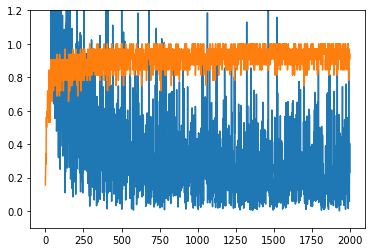

In [5]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)

Y_test_preds = torch.argmax(
    model(torch.tensor(X_test.reshape((-1, 28 * 28))).float()), dim=1
).numpy()
(Y_test == Y_test_preds).mean()

In [6]:
# GPU
device = torch.device("cuda:0")
model = MnistNet().to(device)
BS = 32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
X_train_cuda = torch.tensor(X_train.reshape((-1, 28 * 28))).float().to(device)
Y_train_cuda = torch.tensor(Y_train).long().to(device)

for i in (t := trange(2000)) :
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = X_train_cuda[samp]
    Y = Y_train_cuda[samp]

    out = model(X).to(device)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    loss, accuracy = (loss.item(), accuracy.item())
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.22 accuracy 0.94: 100%|██████████| 2000/2000 [00:03<00:00, 540.65it/s]


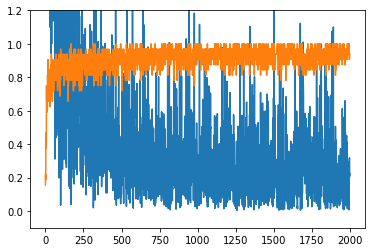

In [7]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)

In [8]:
Y_test_preds = (
    torch.argmax(
        model(torch.tensor(X_test.reshape((-1, 28 * 28))).float().to(device)), dim=1,
    )
    .cpu()
    .numpy()
)
(Y_test == Y_test_preds).mean()

0.9434

In [9]:
samp = [0, 1, 2, 3]
model.zero_grad()
m2 = model.to("cpu")

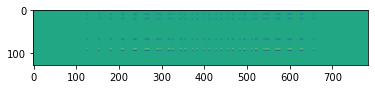

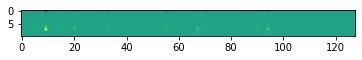

In [10]:
# compute gradients in torch

out = m2(torch.tensor(X_test[samp].reshape((-1, 28 * 28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [11]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x


def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28 * 28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()


numpy_eval()

0.9434

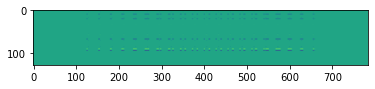

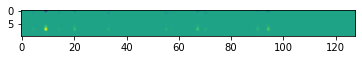

In [12]:
# numpy forward and backward pass


def logsumexp(x):
    # return np.log(np.exp(x).sum(axis=1))
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x - c.reshape((-1, 1))).sum(axis=1))


def forward_backward(x, y):
    # training
    out = np.zeros((len(y), 10), np.float32)
    out[range(out.shape[0]), y] = 1

    # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)

    # training in numpy (super hard!)
    # backward pass

    # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y)

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))

    # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)

    return x_loss, x_l2, d_l1, d_l2


samp = [0, 1, 2, 3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(
    X_test[samp].reshape((-1, 28 * 28)), Y_test[samp]
)

imshow(d_l1.T)
figure()
imshow(d_l2.T)